# GlueNET logika



## Uvod

Ova kratka skripta bi trebala da pomogne u opisu logike koja je primenjena prilikom obrade podataka koji dolaze sa PLC-a.

Postoji nekoliko važnih napomena.
1. Podaci koji se ovde koriste su statički i nepromenjivi, ali kod je pisan tako da se to veoma lako može zameniti dinamičkim, real time podacima.
2. Kod se može izvršavati ove i to pritiskom Ctrl+ENTER. Ukoliko se koriste podaci iz prethodnih ćelija, taj deo koda mora biti izvršen. Najbolje bi bilo izabrati 'Run All' opciju iz 'Cell' menija.
3. Kod se može menjati.

## Uzimanje podataka sa servisa

Pre svega je potrebno importovati odgovarajuće biblioteke koje se koriste u kodu. Njih nema potrebe dodatno objašnjavati.

In [234]:
import urllib.request
import urllib.parse
import json
import matplotlib.pyplot as plt
import numpy as np
import random
import pylab
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns
from numpy import random

Dalje ćemo izvrštit HTTP get metodu kako bismo dobili sirove podatke koji su došli sa PLC-a. Ovaj servis nam vraća privremene podatke koji su izvučeni iz postojeće baze samo za svrhu testiranja.

Trenutni podaci su iz avgusta 2016.

In [235]:
target_uri = 'http://gluenetapi.azurewebsites.net/api/Sensorparser?startDate=2016-08-12%2003:37:17&endDate=2016-08-12%2008:14:20'
url = target_uri

request = urllib.request.Request(url)
response = urllib.request.urlopen(request)

json_string = str(response.read())

Zatim ćemo to pretvoriti u JSON objekat.

In [236]:

json_string = json_string[2:]
json_string = json_string[:-1]
json_data = json.loads(json_string)

## Obrada podataka

Potrebno je potom dati početne vrednosti promenjivim koje će se koristiti u obradi.

Svi kumulativi su rađeni tako što se pretpostavlja da je šarža aktivna. Ovde nije implementirana logika da li šarža aktivna.

Napomena. Trenutno je na web serveru ubačena logika koja ovde fali. Da li je šarža aktivna ili nije, koji bottle counter se uzima u obzir i slične stvari.

In [237]:
#prethodna vrednost (na i-1-om mestu) koja dolazi sa PLC-a. Potrebna je zbog računice
prev_lc1 = int(json_data[0]['LC1'])       
prev_lc2 = int(json_data[0]['LC2'])       
prev_btlcntr1 = int(json_data[0]['BTLCNTR1'])
prev_btlcntr2 = int(json_data[0]['BTLCNTR2'])
#kumulativi
lc1cum = 0                                
lc2cum = 0
btlcntr1cum = 0
btlcntr2cum = 0
#sistemska korekcija. BTLCNTR ide do 10000 pa se vraća na nulu
corection = 10000
#Liste koje ćemo koristiti za prikaz krajnjeg proračuna
lcdiffsbefore = []
weights = []
bottles = []
lcdiffs = []
btldiffs = []
mean = []
mean21 = 0.5
mean21List = []

## Iteracije

Može se početi sa obradom podataka u svakoj iteraciji. Trebalo bi napomenuti da se ovde unapred znalo koji bottle counter se koristi i koja vaga. To je na web servisu namešteno da prepoznaje automatski.

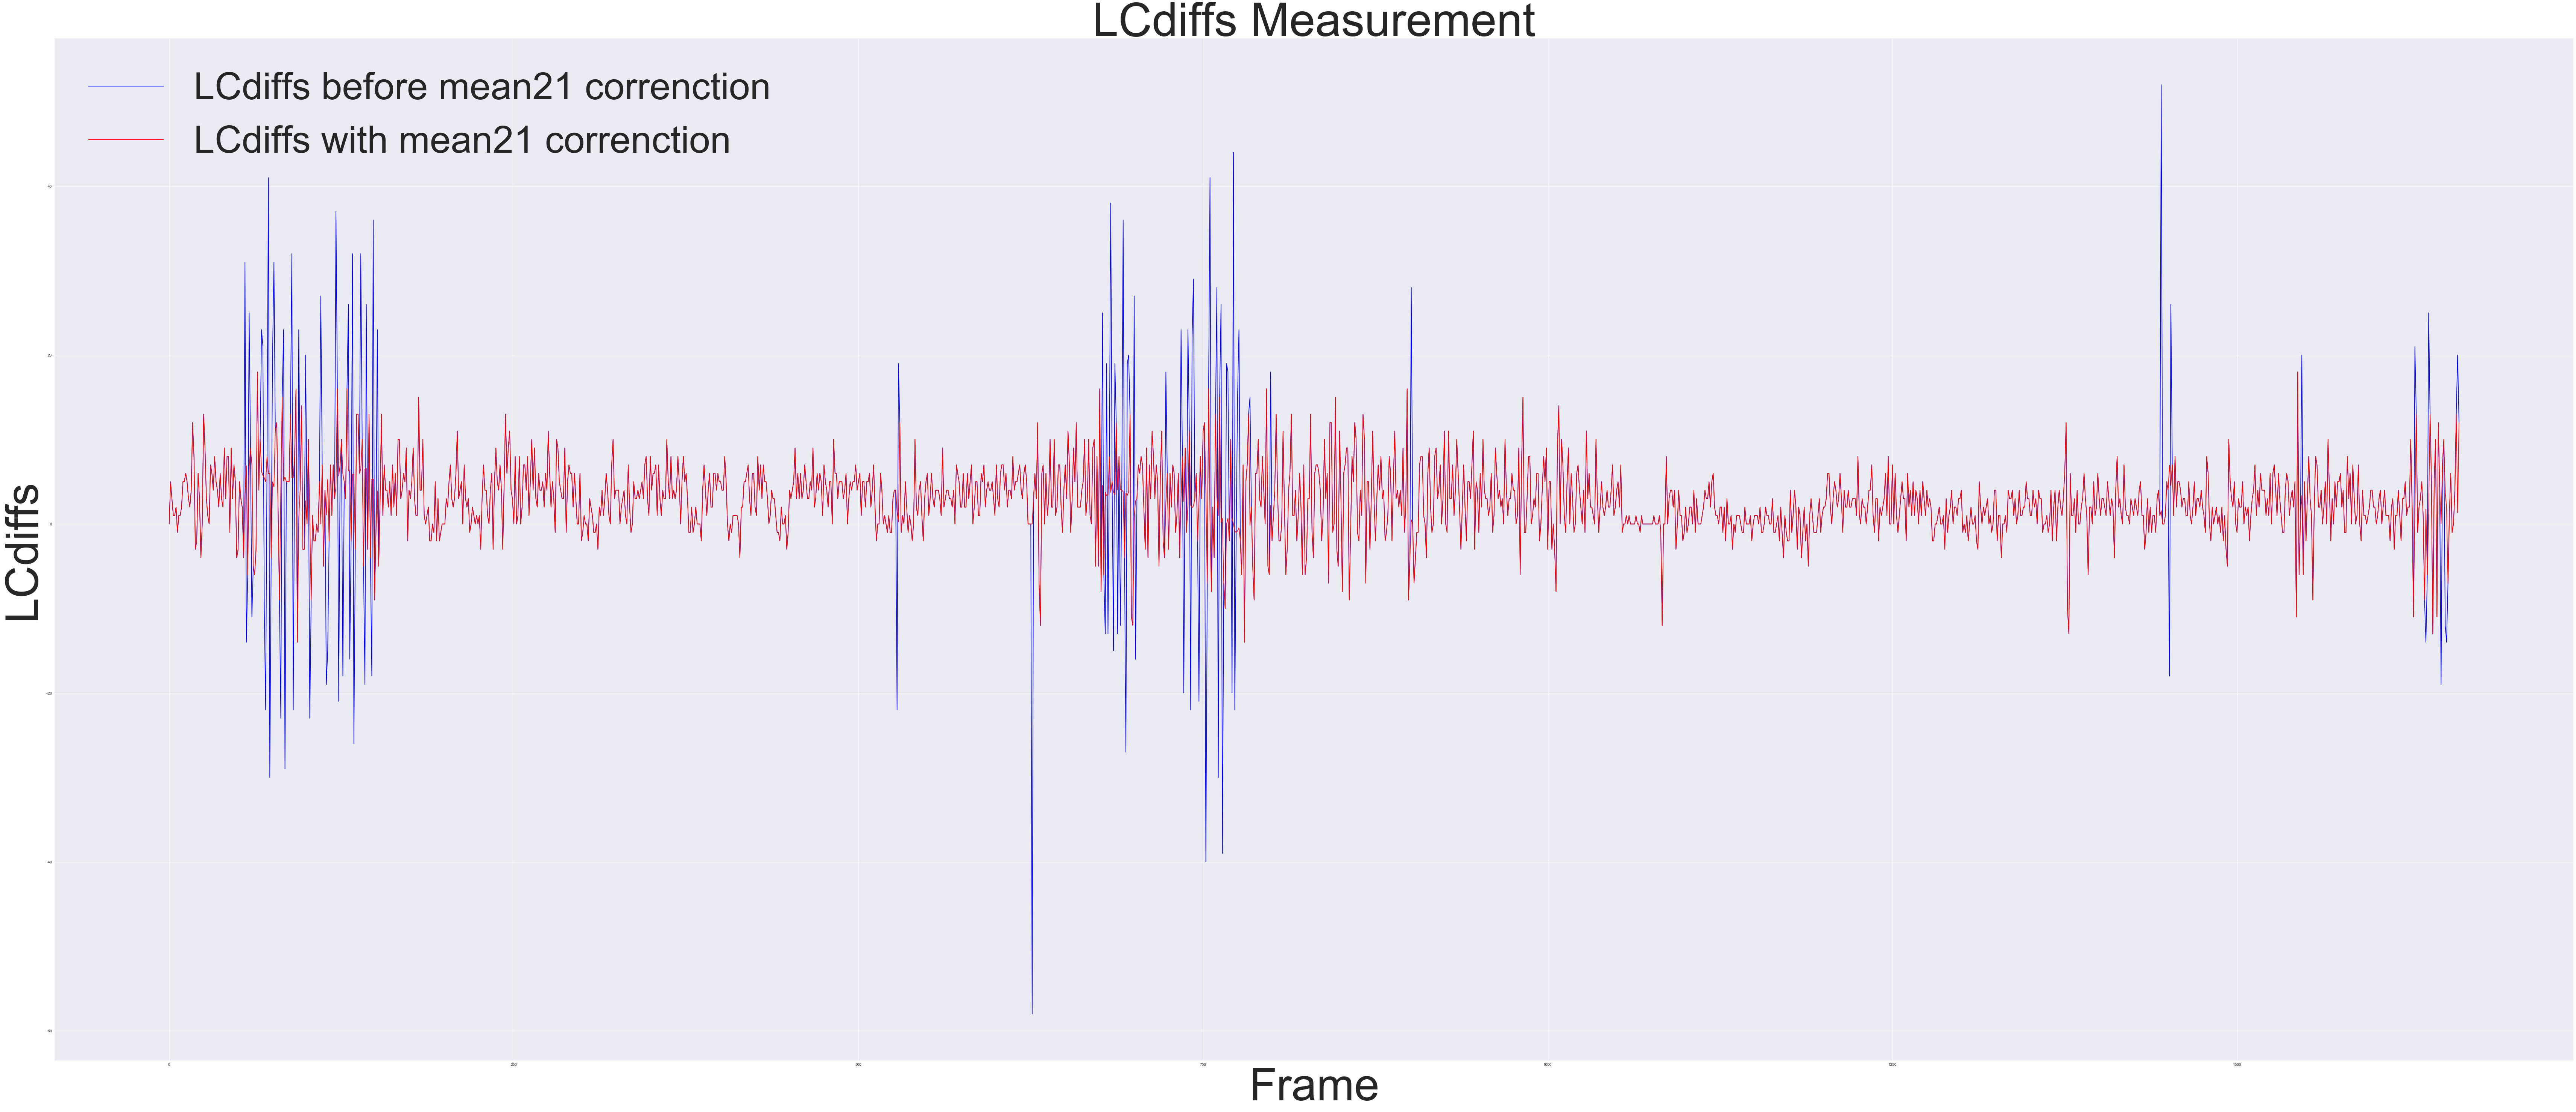

In [238]:
for j in json_data:
    if int(j['FrameType']) == 1:   #uzimamo samo vrednosti sa PLC-a
        #trenutne vrednosti koje dolaze sa PLC-a, odn. u ovom slučaju iz JSON-a
        curr_lc1 = int(j['LC1'])
        curr_lc2 = int(j['LC2'])
        curr_btlcntr1 = int(j['BTLCNTR1'])
        curr_btlcntr2 = int(j['BTLCNTR2'])

        #Korekcije koje se vrše u slučaju da je brojač prešao 10000 i ukoliko je zamenjena kanta na vagi ili neko zgazio na vagu
        if prev_btlcntr1>9500 and curr_btlcntr1<500:
            prev_btlcntr1 = prev_btlcntr1 - corection
        if prev_btlcntr2>9500 and curr_btlcntr2<500:
            prev_btlcntr2 = prev_btlcntr2 - corection
        if abs(prev_lc1 - curr_lc1)>100:
            prev_lc1 = curr_lc1
        if abs(prev_lc2 - curr_lc2)>100:
            prv_lc2 = curr_lc2
            
        #Obračun potrošnje lepka u trenutnom frame-u kao i broj boca u tom frame-u
        lc1_diff = prev_lc1 - curr_lc1  
        lc2_diff = prev_lc2 - curr_lc2
        btlcntr1_diff = curr_btlcntr1 - prev_btlcntr1
        btlcntr2_diff = curr_btlcntr2 - prev_btlcntr2
        
        #ubacujemo u listu vrednosti pre bilo kakve izmene kako bismo mogli da uporedimo rezultate
        lcdiffsbefore.append(lc1_diff)

        #Naredni korak je usrednjavanje vrednosti koje nisu moguće
        #15 je uzeta vrednost sa grafika. Trebalo bi je dodatno definisati
        #mean21 je prosek potrošnje lepka po boci izračunat za prethodnih 21 frejmova
        #mean21 se update-uje u svakom koraku. Početna vrednost je uzeta proizvoljno. Ona se brzo prilagodi.
        if abs(mean21*btlcntr2_diff - lc1_diff) > 15:
             lc1_diff = mean21*btlcntr2_diff

        #računanje kumulativa za datu šaržu
        lc1cum = lc1cum + lc1_diff
        lc2cum = lc2cum + lc2_diff
        btlcntr1cum = btlcntr1cum + btlcntr1_diff
        btlcntr2cum = btlcntr2cum + btlcntr2_diff

        #kreće račun proseka potrošnje lepka po boci
        #potrošnja po boci postoji samo ukoliko je btl counter različit od nule
        if btlcntr2_diff != 0:
            lcpb = lc1_diff/float(btlcntr2_diff)
            if len(mean) > 0:
                #Naredna provera je još jedno usrednjavanje grešaka. Ukoliko potrošnja po boci prelazi 0,2 grama, 
                #potrebno je uzeti prethodnu vrednost.
                if abs(lcpb) > 0.2:
                    lcpb = mean[len(mean)-1]
            mean.append(lcpb)
        else:
            mean.append(0.0)

        #mean21 se računa tako što se uzme prosek prethodnih 21 merenja i za sve vrednosti koje su različite od nule izračuna prosek.
        #ukoliko ne postoji 21 merenje (na početku šarže), uzima se koliko ima
        mean21 = 0.0
        sum = 0.0
        n = 0
        br = 0
        if len(mean) > 21:
            n = len(mean) - 21
        for i in range(n, len(mean)):
            if mean[i] != 0:
                sum = sum + mean[i]
                br = br + 1
        if i > 0 and  br > 0:
            mean21 = sum/br
        else:
            mean21 = sum
            
        mean21List.append(mean21)

        #punjenje lista koje se kasnije koriste za prikaz
        lcdiffs.append(lc1_diff)         #usrednjena lista lcdiff-ova. Pre filtriranja
        btldiffs.append(btlcntr2_diff)
        weights.append(lc1cum)
        bottles.append(btlcntr2cum)

        #Budući da nam računica zavisi od prethodne vrednosti, potrebno je sačuvati trenutne vrednosti kao prethodne
        prev_lc1 = curr_lc1
        prev_lc2 = curr_lc2
        prev_btlcntr1 = curr_btlcntr1
        prev_btlcntr2 = curr_btlcntr2
        
pylab.figure(figsize=(120,50))
pylab.plot(range(len(lcdiffsbefore)),lcdiffsbefore,'b',range(len(lcdiffs)),lcdiffs,'r')
pylab.xlabel('Frame', fontsize=120)
pylab.ylabel('LCdiffs', fontsize=120)
pylab.title('LCdiffs Measurement', fontsize=124)
pylab.legend(('LCdiffs before mean21 correnction','LCdiffs with mean21 correnction'), fontsize=100)
#naredna linija koda je zakomentarisana ali ako se otkomentariše, može se kontrolisati prikaz na x i y osi
#pylab.axis([0,1000,-60,90])              #pylab.axis([x,x1,-y,y1])
pylab.show()


# Filter

## Opis filtera

Radi se preko unsupervised learning algoritma, može biti i real time obrada. Algoritam radi tako što na osnovu prethodne vrednosti pretpostavi narednu i izvrši mali pomeraj prema vrednostima koje dolaze sa senzora. Taj mali pomeraj je u stvari težinski faktor koji se update-uje u svakoj iteraciji i zavisi od odstupanja pretpostavljene vrednosti i stvarne vrednosti. Ukoliko su podaci sa senzora nepouzdani i imaju velika odstupanja od pretpostavljene vrednosti, uticaj podataka sa senzora je manji i obrnuto.

U kodu postoji promenjiva 'a' koja je veza sa fizičkim sistemom, tj. to matrica prelaska stanja. Može se postaviti da bude 1. Tada je funkcija glatka i ne reaguje brzo na promene. Ukoliko postavimo da je matrica prelaska zavisna od sistema tada moramo uvesti broj boca u datom frame-u. Tada je a=mean21, tj. prosečna porošnja po boci u prethodnih 21 merenja. Dok je pretpostavljeno stanje LCpredicted=mean21*btldiffs[z], prosečna potrošnja po boci u prethodnih 21 merenja puta broj boca u trenutnom frame-u.

Parametar q poprilično utiče na filter. Pa tako, ukoliko je njegova vrednost 0.001 filtrirana funkcija će biti više uprosečena i neće toliko brzo reagovati na promene, dok ukoliko postavimo da bude 0.1, tada prati nefiltrirane podatke ali smanjuje pikove.
Algoritam funkcioniše tako što prvo odradi predviđenu vrednost LC na osnovu prethodnog stanja. U našem slučaju mean21 sadrži prethodno stanje. Takođe, predvidi standardnu devijaciju trenutnog merenja na osnovu prethodog. Tako imamo update-ovanu grešku merenja u svakom koraku. Nakon toga algoritam radi update promenjivih, tj. predviđeno LC pomeri za određenu vrednost ka pravoj vrednosti koja dolazi sa senzora. To za koliko je pomeri je parametar koji se update-uje u svakom koraku i zavisi od toga koliko 'verujemo' senzoru. Nakon toga update-ujemo i grešku koju ćemo koristiti u proračunu u sledećem koraku.

Potrebno je napomenuti da ovaj algoritam treba takođe da radi u for petlji (odnosno sa real time podacima kada budemo testirali), ali je izdvojen da bi zasebno bio objašnjen i menjan. Zato je i deo kod računanja mean21 promenjive ponovljen.

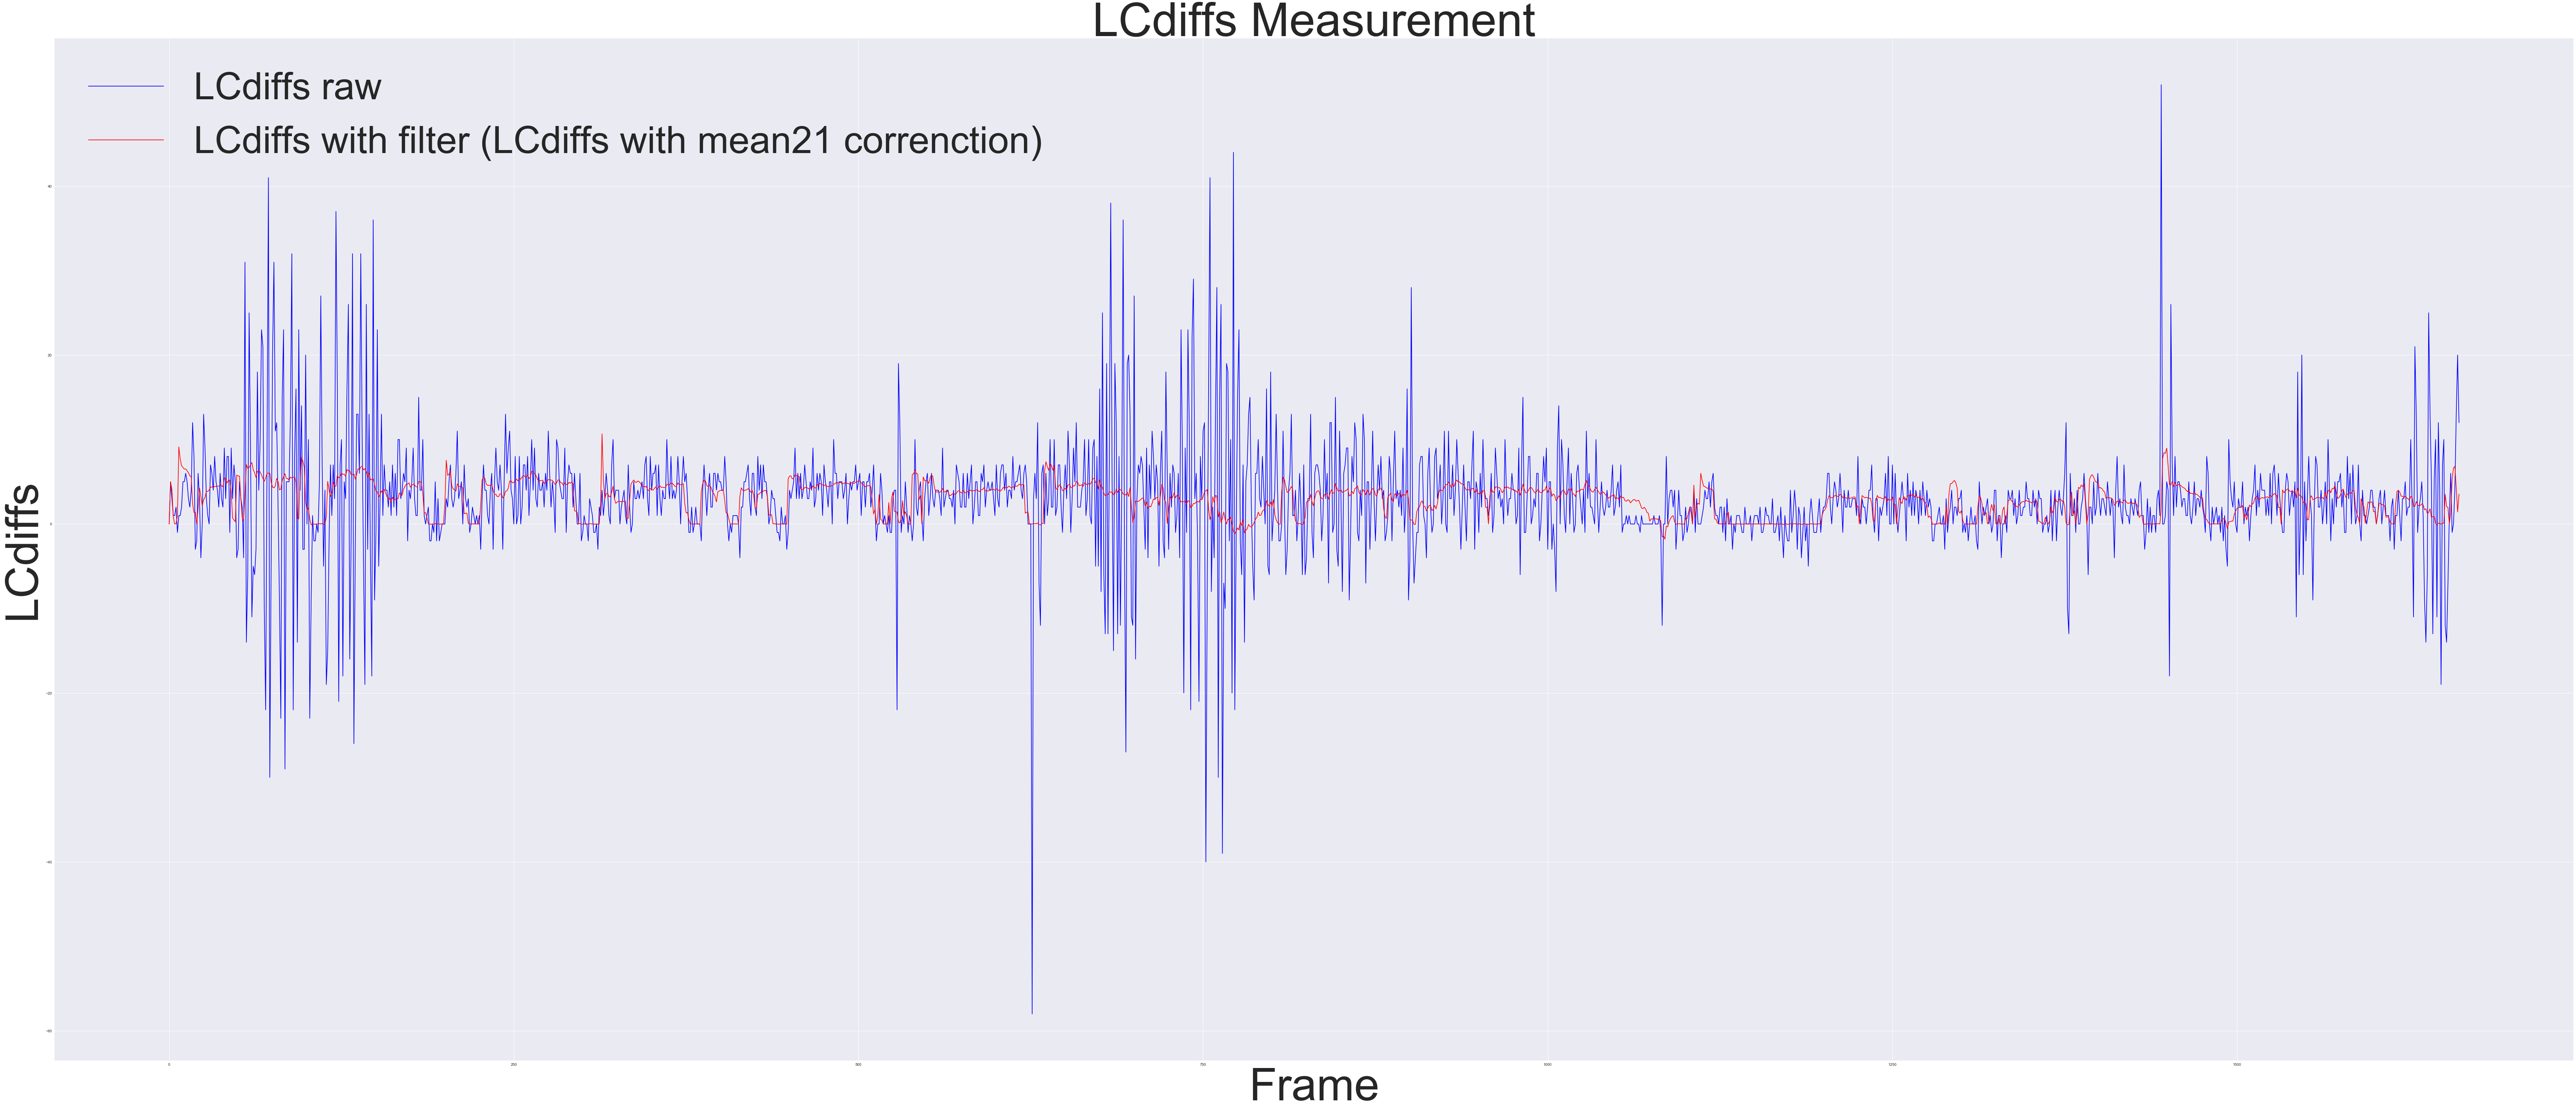

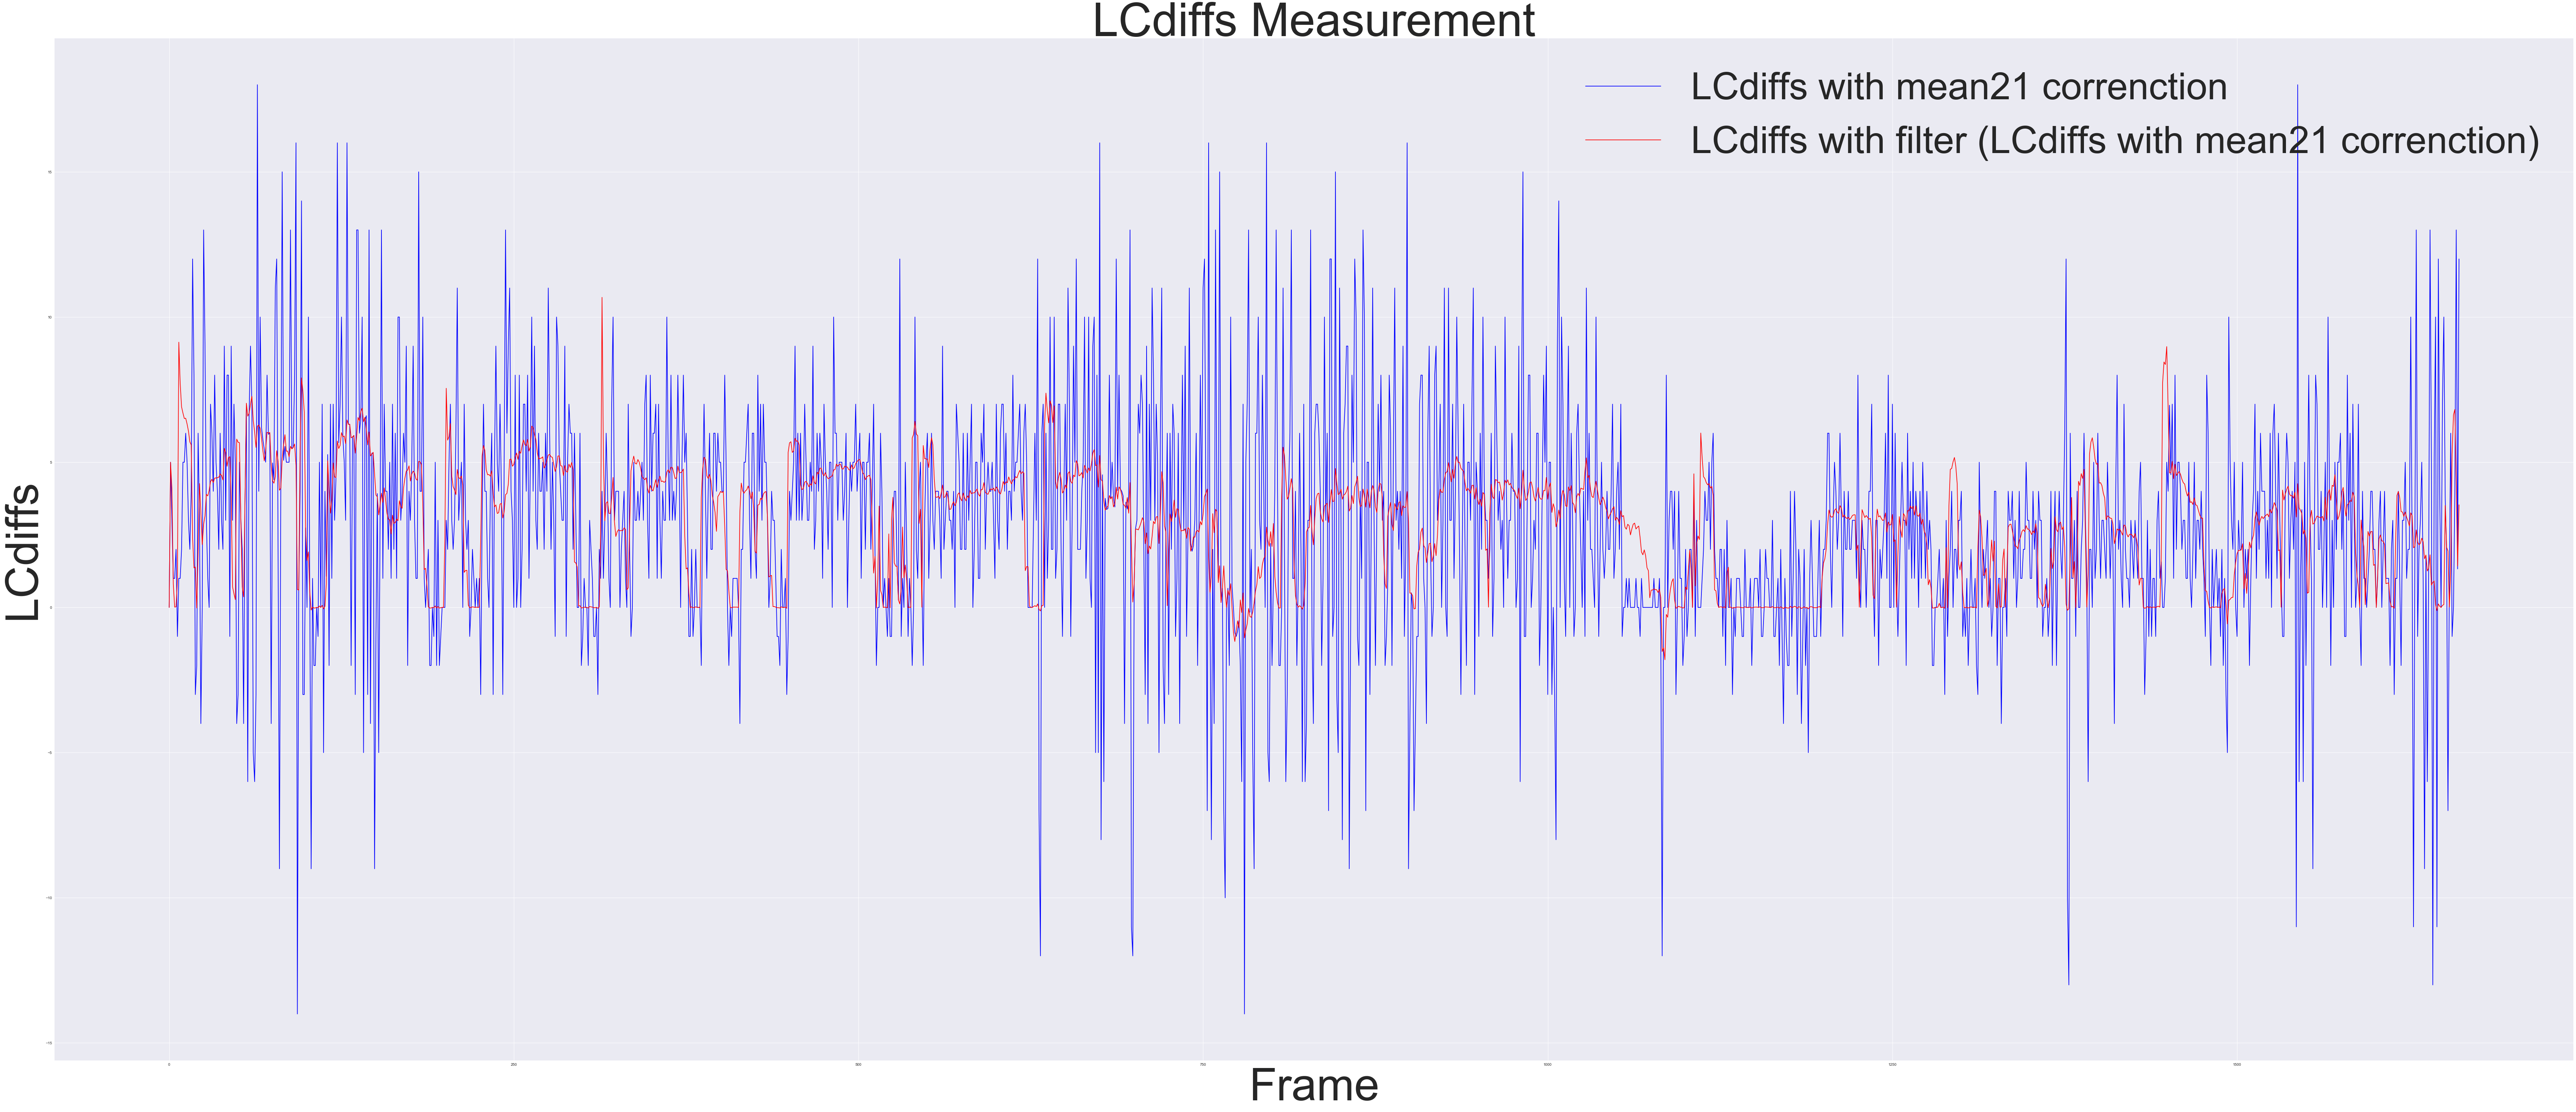

In [239]:
#pocetna stanja
LCprev = float(lcdiffs[0])
BTLcumprev = 1
Wprev = 1.0
Pkprev = 1.0
Hprev = 1
q = 0.001

lcks = []

for z in range (0, len(lcdiffs)):

    #prediction
    #a = 1
    a = mean21List[z]

    #ukoliko je a=1
    #LCpredicted = float(a*LCprev)               #x[k] = a*x[k-1] + Buk
    
    #ukoliko je a=mean21List[z]
    LCpredicted = float(a*btldiffs[z])           #x[k] = a*x[k-1] + Buk
    Pk = a*Pkprev*a + q                          #p[k] = a * p[k - 1] * a + q

    #update 
    y = float(lcdiffs[z]) - Hprev*LCpredicted   #y = z - h * x[k]
    kg = Pk*Hprev/(Hprev*Pk*Hprev + 0.1)        #kg = p * h / (h * p * h + r)
    LCk = LCpredicted + kg*y                    #x[k] = x[k] + kg * y
    Pk = (1 - Hprev*kg)*Pk                      #p[k] = (1 - kg * h) * p[k]

    
    LCprev = LCk
    Pkprev = Pk
        
    lcks.append(LCk)

pylab.figure(figsize=(120,50))
pylab.plot(range(len(lcdiffsbefore)),lcdiffsbefore,'b',range(len(lcks)),lcks,'r')
pylab.xlabel('Frame', fontsize=120)
pylab.ylabel('LCdiffs', fontsize=120)
pylab.title('LCdiffs Measurement', fontsize=124)
pylab.legend(('LCdiffs raw','LCdiffs with filter (LCdiffs with mean21 correnction)'), fontsize=100)
#naredna linija koda je zakomentarisana ali ako se otkomentariše, može se kontrolisati prikaz na x i y osi
#pylab.axis([0,1000,-60,90])              #pylab.axis([x,x1,-y,y1])
pylab.show()
    
pylab.figure(figsize=(120,50))
pylab.plot(range(len(lcdiffs)),lcdiffs,'b',range(len(lcks)),lcks,'r')
pylab.xlabel('Frame', fontsize=120)
pylab.ylabel('LCdiffs', fontsize=120)
pylab.title('LCdiffs Measurement', fontsize=124)
pylab.legend(('LCdiffs with mean21 correnction','LCdiffs with filter (LCdiffs with mean21 correnction)'), fontsize=100)
#naredna linija koda je zakomentarisana ali ako se otkomentariše, može se kontrolisati prikaz na x i y osi
#pylab.axis([0,1000,-60,90])              #pylab.axis([x,x1,-y,y1])
pylab.show()



Prvi grafik predstavlja poređenje sirovih podataka sa vage, kao i filtriranih podataka, ali ne sirovih nego nakon one mean21 korekcije.
Drugi grafik predstavlja poređenje nefiltriranih i filtriranih podataka koji su već usrednjeni.



Testa radi može se proveriti i pustiti kroz filter vrednosti pre bilo kakve korekcije (tj. pre upotrebe usrednjavanja vrednosti koristeći mean21 ukoliko vrednost iskače previše iz normale). To tada izgleda ovako:

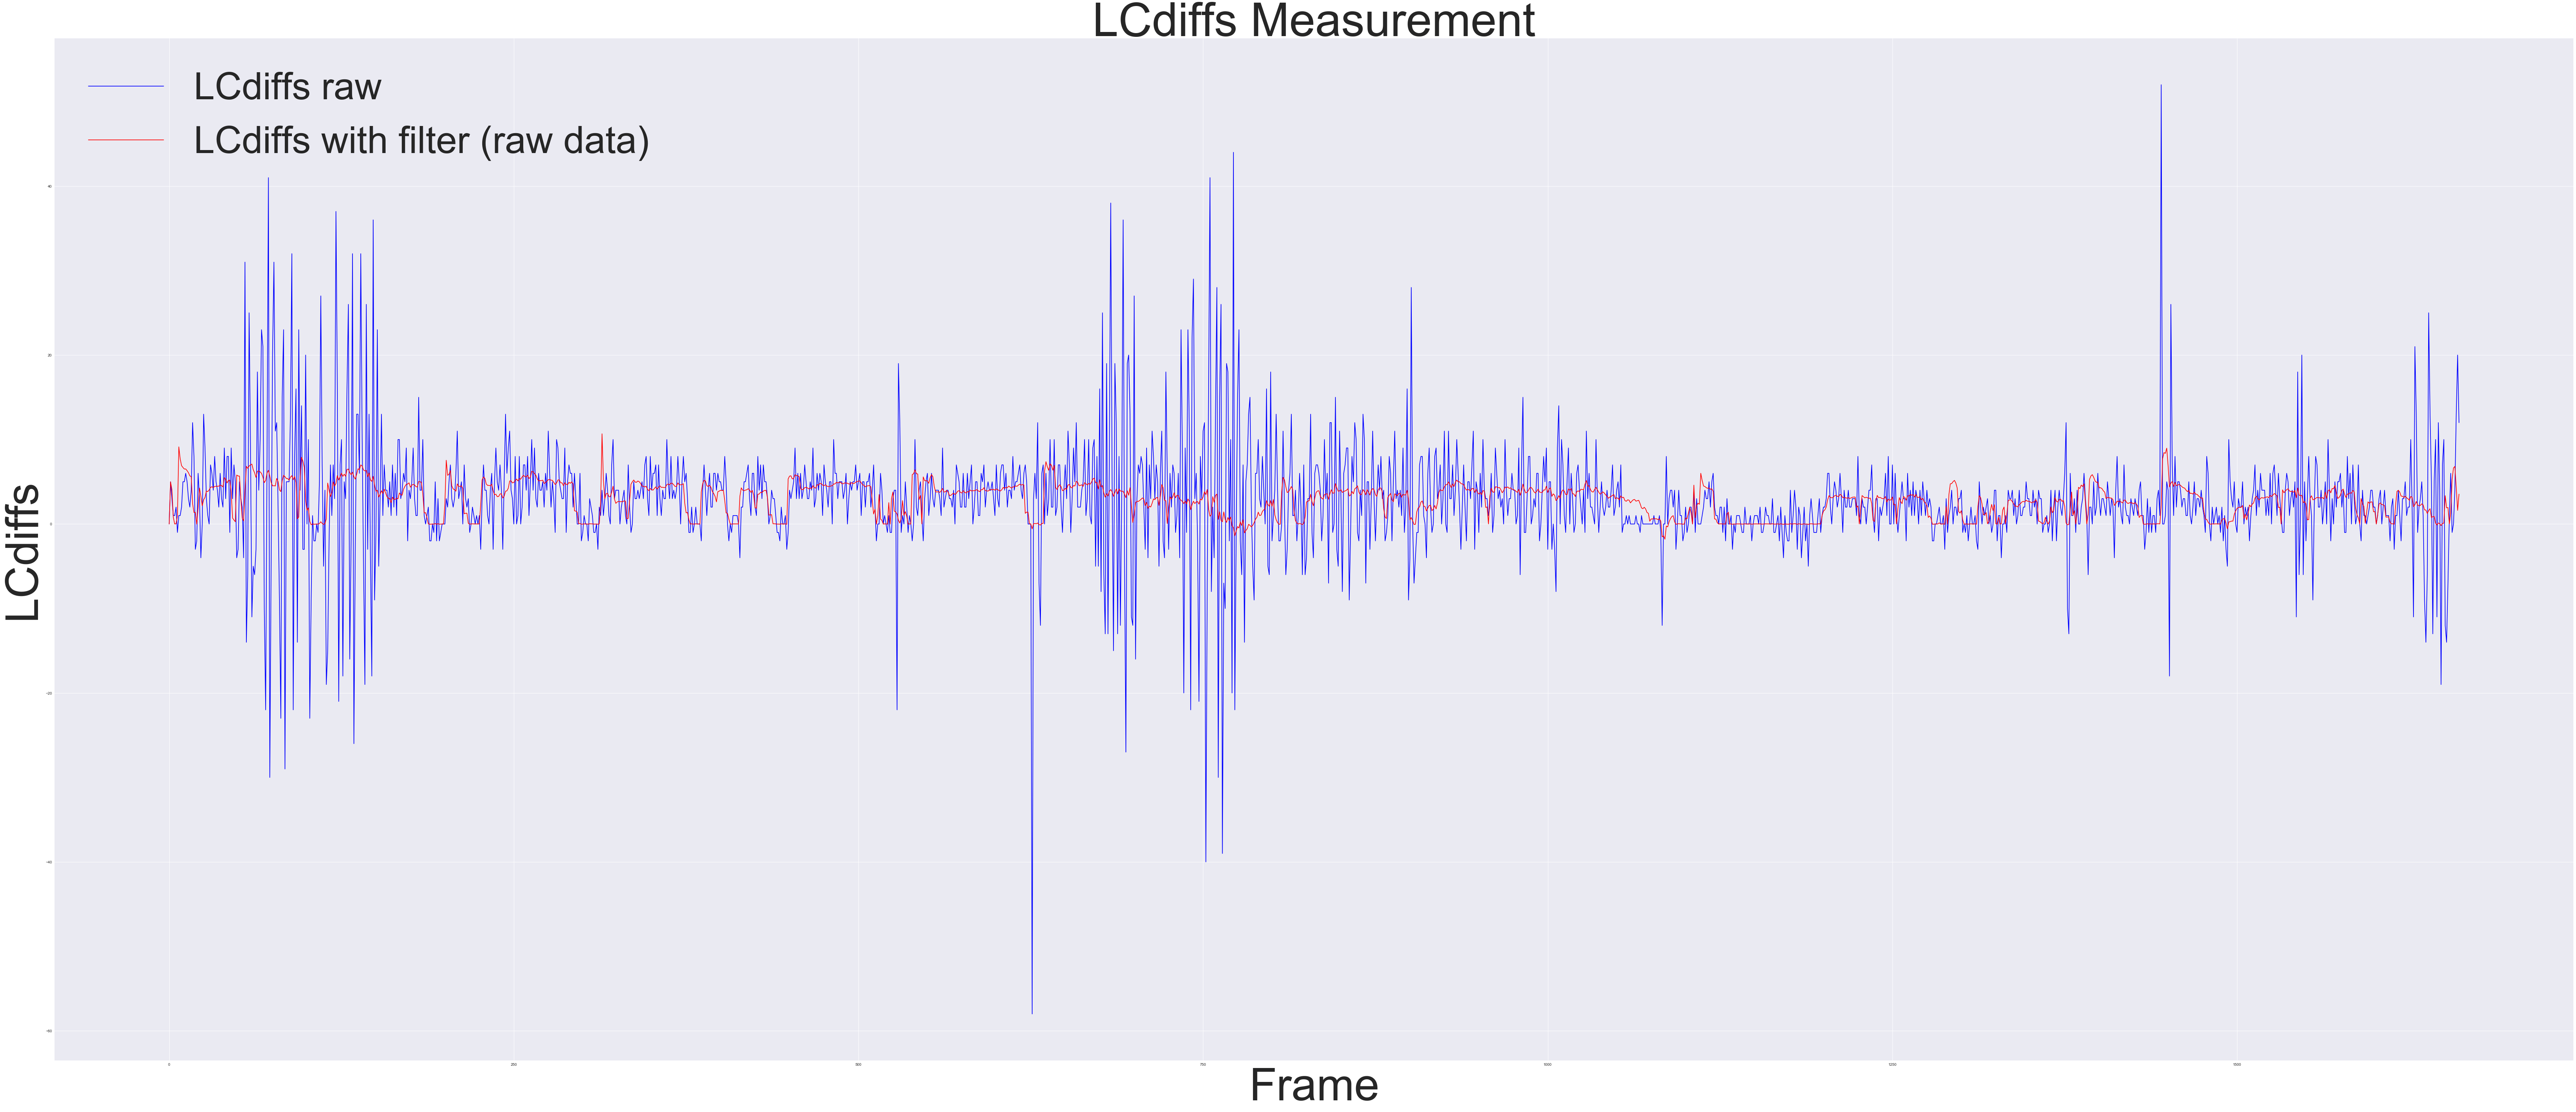

In [240]:
#pocetna stanja
LCprev = float(lcdiffsbefore[0])
BTLcumprev = 1
Wprev = 1.0
Pkprev = 1.0
Hprev = 1
q = 0.001

lcks = []

for z in range (0, len(lcdiffsbefore)):

    #prediction
    #a = 1
    a = mean21List[z]

    #ukoliko je a=1
    #LCpredicted = float(a*LCprev)               #x[k] = a*x[k-1] + Buk
    
    #ukoliko je a=mean21List[z]
    LCpredicted = float(a*btldiffs[z])           #x[k] = a*x[k-1] + Buk
    Pk = a*Pkprev*a + q                          #p[k] = a * p[k - 1] * a + q

    #update 
    y = float(lcdiffsbefore[z]) - Hprev*LCpredicted   #y = z - h * x[k]
    kg = Pk*Hprev/(Hprev*Pk*Hprev + 0.1)        #kg = p * h / (h * p * h + r)
    LCk = LCpredicted + kg*y                    #x[k] = x[k] + kg * y
    Pk = (1 - Hprev*kg)*Pk                      #p[k] = (1 - kg * h) * p[k]

    
    LCprev = LCk
    Pkprev = Pk
        
    lcks.append(LCk)

pylab.figure(figsize=(120,50))
pylab.plot(range(len(lcdiffsbefore)),lcdiffsbefore,'b',range(len(lcks)),lcks,'r')
pylab.xlabel('Frame', fontsize=120)
pylab.ylabel('LCdiffs', fontsize=120)
pylab.title('LCdiffs Measurement', fontsize=124)
pylab.legend(('LCdiffs raw','LCdiffs with filter (raw data)'), fontsize=100)
#naredna linija koda je zakomentarisana ali ako se otkomentariše, može se kontrolisati prikaz na x i y osi
#pylab.axis([0,1000,-60,90])              #pylab.axis([x,x1,-y,y1])
pylab.show()
    


Prvi grafik predstavlja poređenje sirovih podataka sa vage, kao i filtriranih podataka, ali sirovih foltriranih, pre mean21 korekcije.
